In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import src.preprocessing as prepro
import src.data_handler as data_handler
from src.models import LinealReg

raw_data : data_handler.RawData = data_handler.RawData()

1.1) Utilizo la función de pandas info() para analizar los datos.

In [2]:
# casas_dev.csv

print("\"casas_dev.csv\"\n")
raw_data.casas_dev.info(memory_usage=False)
print("")
print("")
print("Cantidad de filas con uno o más elementos nulos: ", data_handler.get_null_rows(raw_data.casas_dev))
print("")

"casas_dev.csv"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   area        900 non-null    float64
 1   area_units  900 non-null    object 
 2   is_house    900 non-null    int64  
 3   has_pool    900 non-null    int64  
 4   age         770 non-null    float64
 5   price       900 non-null    float64
 6   lat         900 non-null    float64
 7   lon         900 non-null    float64
 8   rooms       828 non-null    float64
dtypes: float64(6), int64(2), object(1)

Cantidad de filas con uno o más elementos nulos:  189



In [3]:
#
#   OBSERVACIONES / POSIBLES CAMBIOS -- 'casas_dev.csv'
#
#   Tipos de datos erróneos:
#   * Las features 'is_house' y 'has_pool' podrían ser booleanos en lugar de enteros.
#   * Las features 'age' y 'rooms' podrían ser enteros en lugar de floats.}
#   Datos incompletos:
#   * La feature 'age' presenta 130 datos nulos.   Podría completarse con el promedio del valor de la feature o remover las filas donde 'age' es nulo.
#   * La feature 'rooms' presenta 72 datos nulos.  Podría completarse con el promedio del valor de la feature o remover las filas donde 'rooms' es nulo.
#   * En total hay 189 filas con elementos nulos.
#   Datos inconsistentes:
#   * La feature 'area' contiene valores numéricos en dos unidades de medida diferentes. Sería conveniente convertir todos los valores a una unidad en común.
#

In [4]:
print(data_handler.are_data_types_uniform(raw_data.casas_dev))

True


CORRECCIONES DATASET

In [5]:
# casas_dev.csv

updated_casas_dev : pd.DataFrame = prepro.correct_data_types(raw_data.casas_dev)
updated_casas_dev : pd.DataFrame = prepro.convert_area_units(updated_casas_dev, 'm2')
updated_casas_dev.info(memory_usage=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   area        900 non-null    Int64  
 1   area_units  900 non-null    string 
 2   is_house    900 non-null    bool   
 3   has_pool    900 non-null    bool   
 4   age         770 non-null    Int64  
 5   price       900 non-null    Int64  
 6   lat         900 non-null    Float64
 7   lon         900 non-null    Float64
 8   rooms       828 non-null    Int64  
dtypes: Float64(2), Int64(4), bool(2), string(1)

1.2)

In [6]:
processed_data : data_handler.ProcessedData = data_handler.ProcessedData(correct_data_types=True, normalize=False, area_units='m2')
processed_data.save_data()
processed_data_nona : data_handler.ProcessedData = data_handler.ProcessedData(correct_data_types=True, normalize=False, area_units='m2', remove_na_rows=True)
processed_data_nona.save_data(ext='nona')
processed_data_normalized : data_handler.ProcessedData = data_handler.ProcessedData(correct_data_types=True, normalize=True, area_units='m2')
processed_data_normalized.save_data(ext='normalized')
processed_data_normalized_nona : data_handler.ProcessedData = data_handler.ProcessedData(correct_data_types=True, normalize=True, area_units='m2', remove_na_rows=True) # Contiene los datos normalizados, con los tipos corregidos, y unidades unificadas.
processed_data_normalized_nona.save_data(ext='normalized_nona')

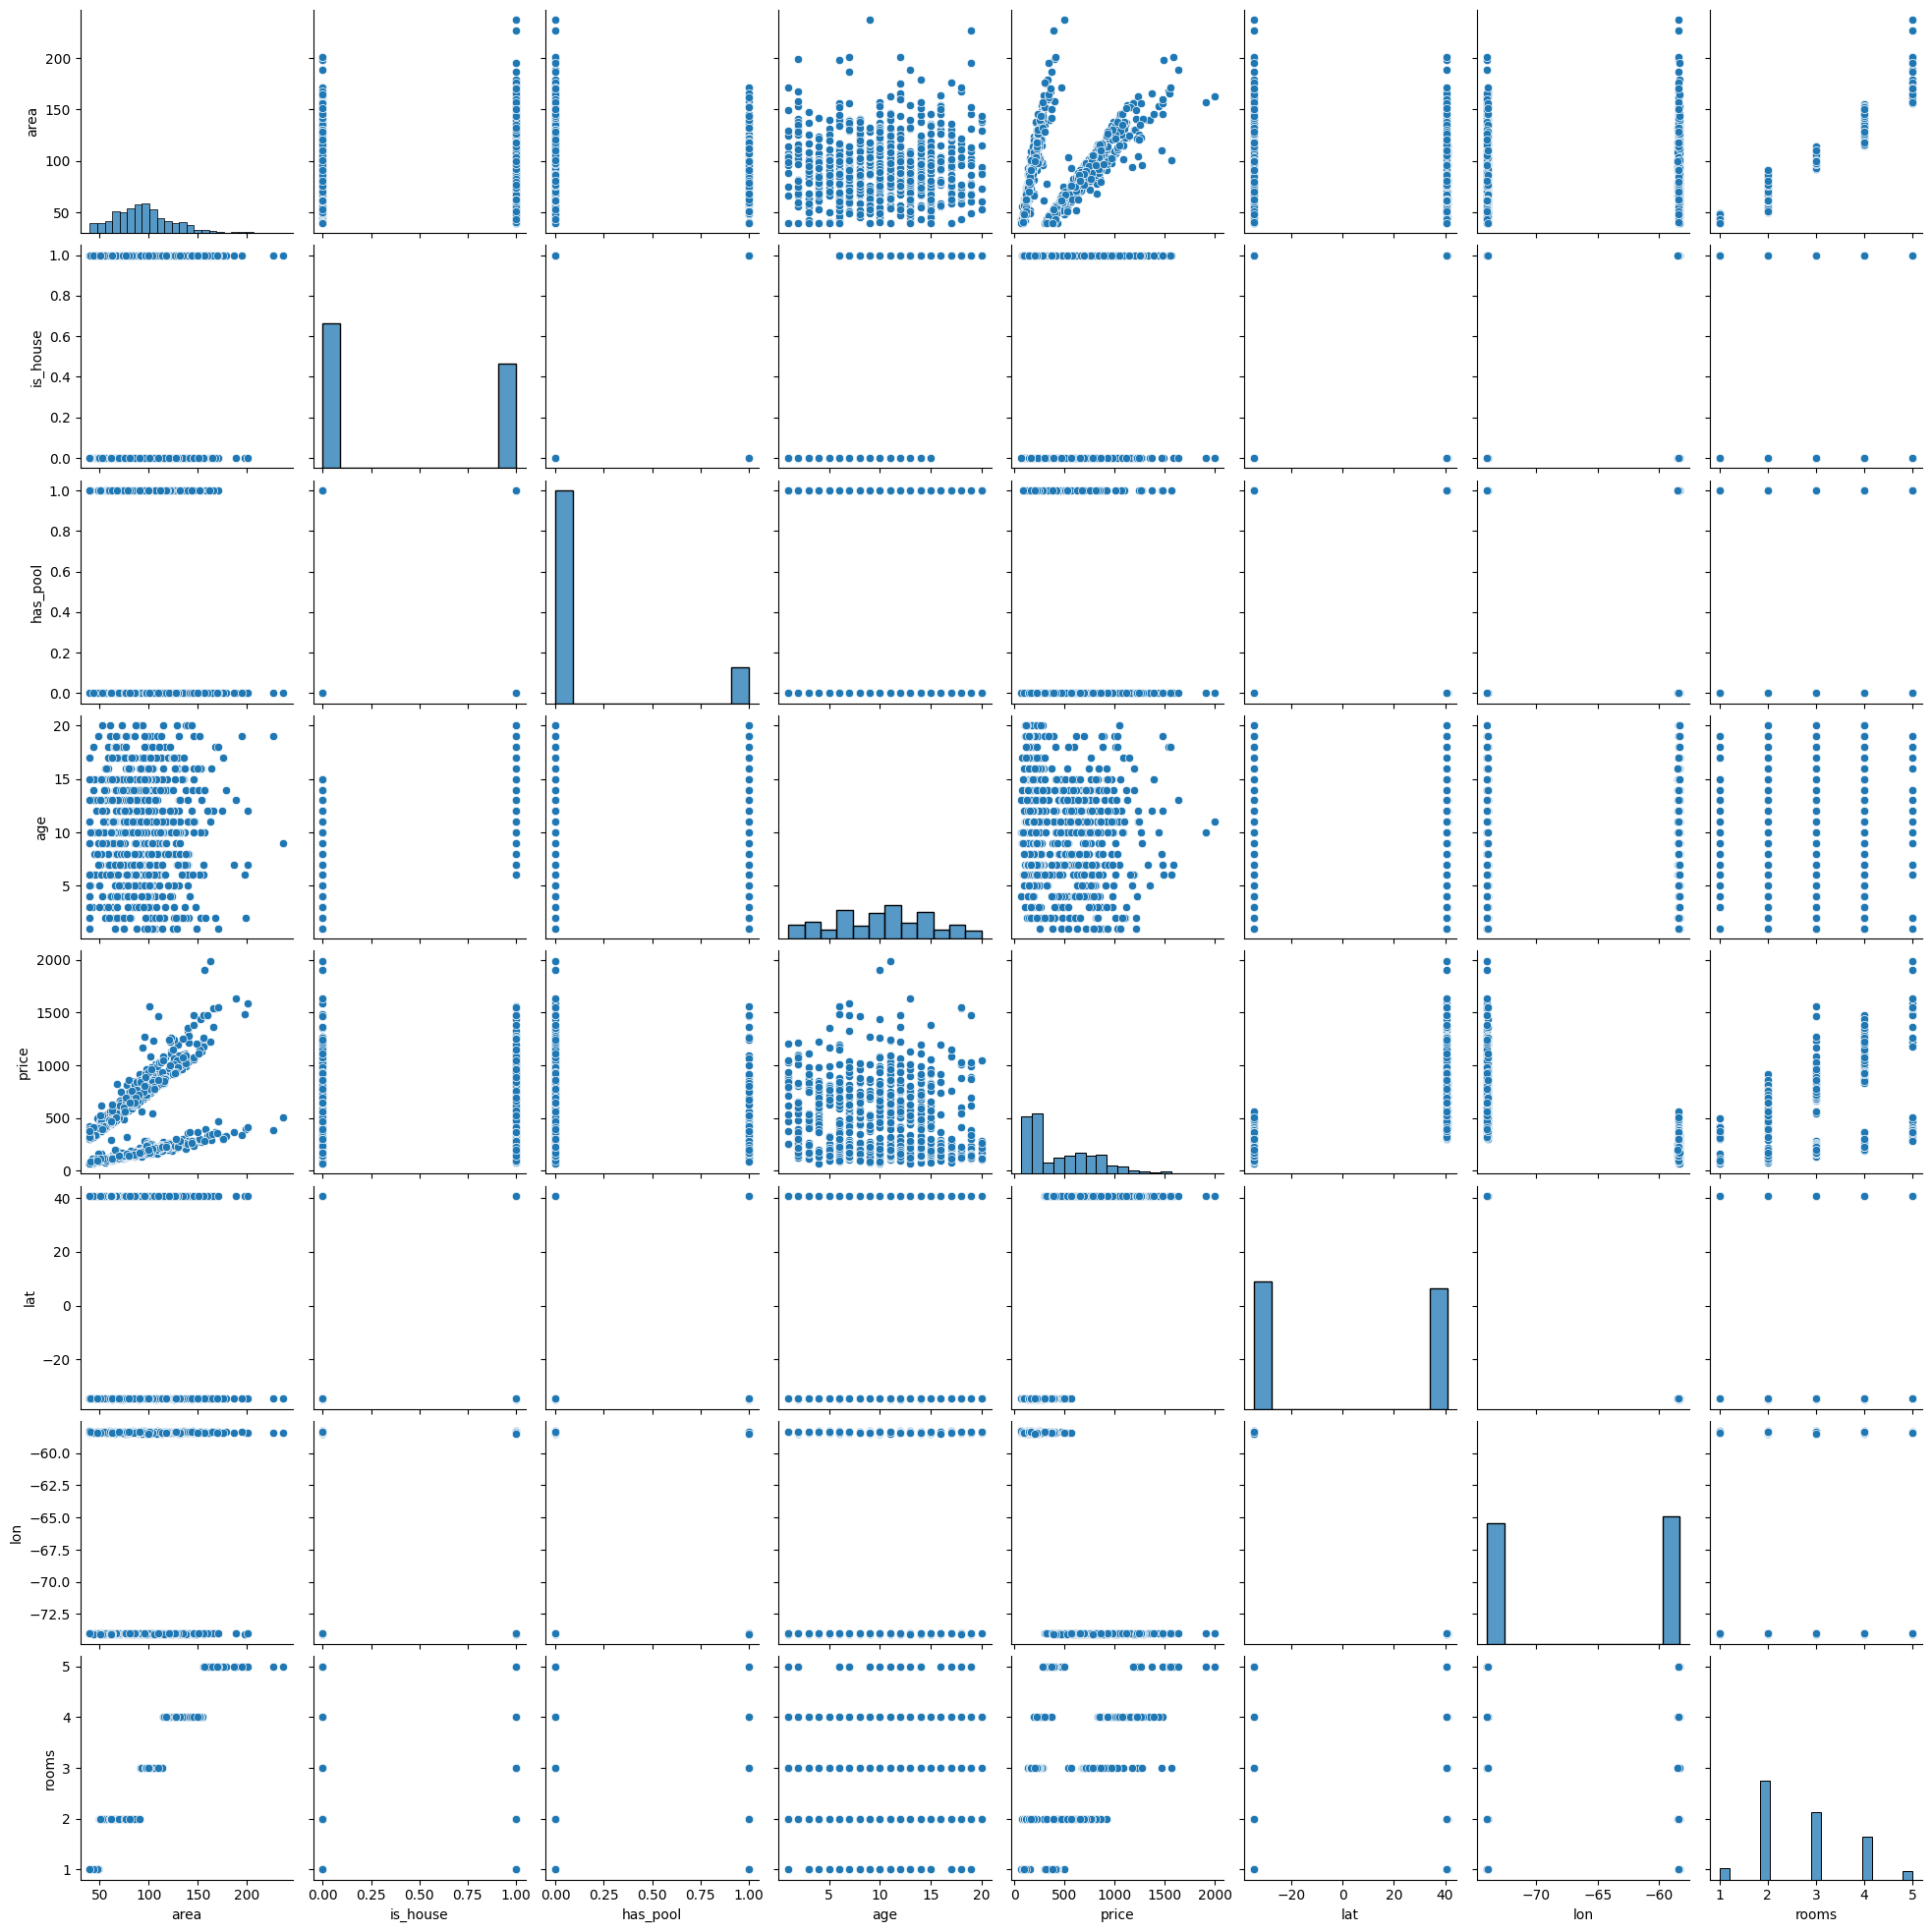

In [7]:
sb.pairplot(data=processed_data.casas_dev, kind='scatter', diag_kind='hist')
plt.show()

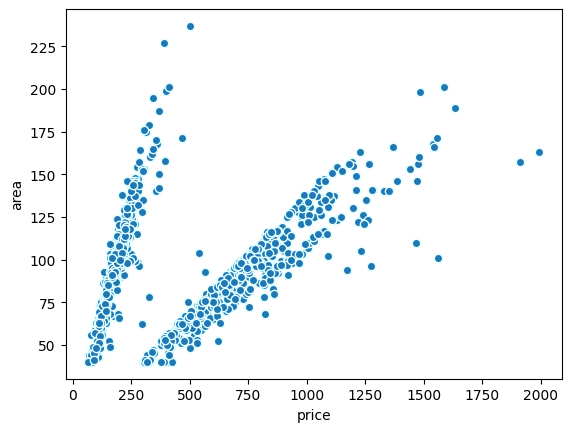

In [8]:
plt.scatter(processed_data.casas_dev['price'], processed_data.casas_dev['area'], edgecolors='lightcyan')
# plt.scatter(casas_dev[casas_dev['lat'] > 0]['price'], casas_dev[casas_dev['lat'] > 0]['area'], edgecolors='lightcyan')
plt.xlabel('price')
plt.ylabel('area')

plt.show()

Sería interesante averiguar qué feature es la encargada de separar los dos clusters.

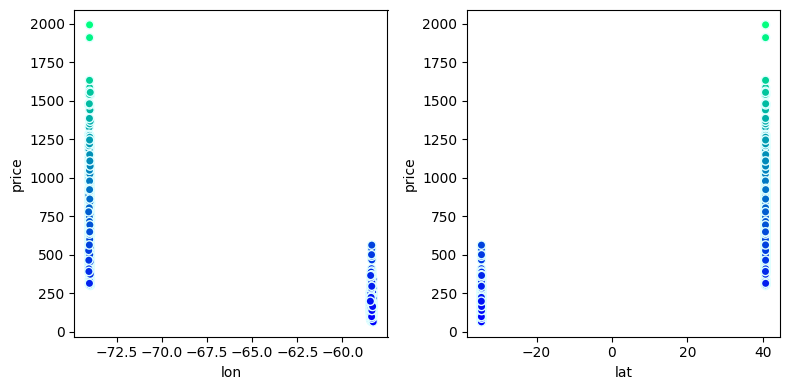

In [9]:
plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
plt.scatter(processed_data.casas_dev['lon'], processed_data.casas_dev['price'], c=processed_data.casas_dev['price'], cmap='winter', edgecolors='lightcyan')
plt.xlabel('lon')
plt.ylabel('price')
plt.subplot(1, 2, 2)
plt.scatter(processed_data.casas_dev['lat'], processed_data.casas_dev['price'], c=processed_data.casas_dev['price'], cmap='winter', edgecolors='lightcyan')
plt.xlabel('lat')
plt.ylabel('price')
plt.tight_layout()
plt.show()

Se puede observar una clara relación entre las features de latitud 'lat' y longitud 'lon'.
Son variables redundantes, ya que es posible estimar la latitud sabiendo la longitud y viceversa.

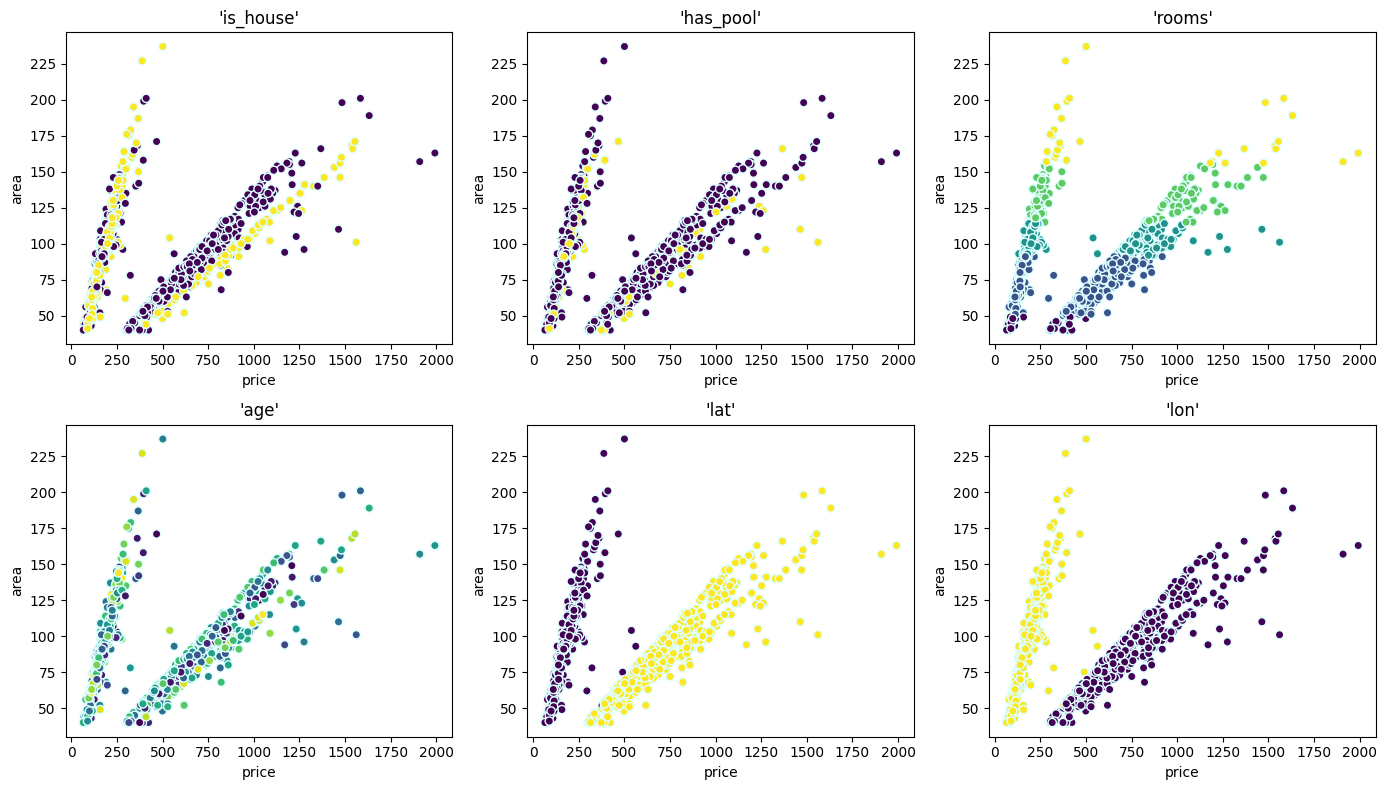

In [10]:
plt.figure(figsize=(14, 8))
other_features : list[str] = ['is_house', 'has_pool', 'rooms', 'age', 'lat', 'lon']
for i in range(1, 7):
    plt.subplot(2, 3, i)
    plt.title(f'\'{other_features[i - 1]}\'')
    plt.scatter(processed_data.casas_dev['price'], processed_data.casas_dev['area'], 
                c=processed_data.casas_dev[other_features[i - 1]], edgecolors='lightcyan')
    plt.xlabel('price')
    plt.ylabel('area')
plt.tight_layout()
plt.show()

En el gráfico anterior se observa una correlación entre el aumento del precio de una casa y su ubicación, también nos sirve para reiterar la redundancia presente en las features de latitud y longitud, siendo cada variable la inversa de la otra.

1.3) Utilizo un dataset normalizado

In [11]:
train : pd.DataFrame
validation : pd.DataFrame
train, validation = data_handler.get_train_and_validation_sets(processed_data_nona.casas_dev, train_fraction=0.8, seed=42)
train_normalized : pd.DataFrame = prepro.normalize_numeric_columns(train)
validation_normalized : pd.DataFrame = prepro.normalize_numeric_columns(train)
other_features = ['area', 'price', 'age', 'lat', 'lon', 'rooms']
train_means : dict[str, float] = {f : train[f].mean() for f in other_features}
train_stds : dict[str, float] = {f : train[f].std() for f in other_features}
validation_means : dict[str, float] = {f : validation[f].mean() for f in other_features}
validation_stds : dict[str, float] = {f : validation[f].std() for f in other_features}


print("Cantidad de muestras del set de entrenamiento: ", train.shape[0])
print("Cantidad de muestras del set de validación:    ", validation.shape[0])

Cantidad de muestras del set de entrenamiento:  569
Cantidad de muestras del set de validación:     142


2 ) Regresión lineal implementada en models.py
- Función de pérdida EC: LinealReg().error_cuadratico_medio()

3.1)

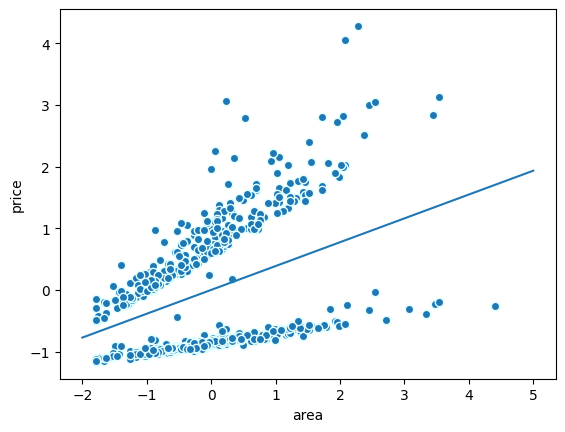

Error Cuadrático Medio:  0.8491750273997409


In [12]:
lin : LinealReg = LinealReg(train_normalized['area'].to_numpy(), train_normalized['price'].to_numpy())
lin.fit_pseudo_inverse()
# lin.fit_gradient_descent(step_size=0.0000000005, tolerance=5000, max_number_of_steps=-1)

plt.scatter(train_normalized['area'], train_normalized['price'], edgecolors='lightcyan')
plt.xlabel('area')
plt.ylabel('price')

x : np.ndarray = np.linspace(-2, 5, 100)
y : list[float] = [lin.coef[0] + (lin.coef[1] * x) for x in x]
plt.plot(x, y)

plt.show()
print("Error Cuadrático Medio: ", lin.error_cuadratico_medio())

3.2)

In [13]:
lin : LinealReg
for caract in ['rooms', 'age', 'lat', 'lon']:
    lin : LinealReg = LinealReg(train_normalized[['area', caract]].to_numpy(), train_normalized['price'].to_numpy())
    lin.fit_pseudo_inverse()
    print(f" \"area\", {f"\"{caract}\"":8}", f"|   Error Cuadrático Medio: {lin.error_cuadratico_medio():3f}", f"|   Error Least Square: {lin.error_least_squares_function():3f}")
# print(processed_data_normalized_nona.vivienda_amanda)
# print(np.array([1, processed_data.vivienda_amanda.iloc[0]['area'], processed_data.vivienda_amanda.iloc[0]['lon']]))
# print(lin.coef)
print("")
processed_vivienda_amanda : pd.DataFrame = prepro.convert_area_units(raw_data.vivienda_amanda, 'm2')
prediction_vivienda_amanda_normalized = lin.coef @ np.array(
                    [1,
                        (processed_vivienda_amanda.iloc[0]['area'] - train_means['area']) / train_stds['area'],
                        (processed_vivienda_amanda.iloc[0]['lon'] - train_means['lon']) / train_stds['lon']
                    ])
prediction_vivienda_amanda = (prediction_vivienda_amanda_normalized * train_stds['price']) + train_means['price']
print(prediction_vivienda_amanda)


 "area", "rooms"  |   Error Cuadrático Medio: 0.838326 |   Error Least Square: 477.007538
 "area", "age"    |   Error Cuadrático Medio: 0.806575 |   Error Least Square: 458.941144
 "area", "lat"    |   Error Cuadrático Medio: 0.144594 |   Error Least Square: 82.274157
 "area", "lon"    |   Error Cuadrático Medio: 0.144665 |   Error Least Square: 82.314557

822.7583568171449


3.3)

In [14]:
print((processed_data.casas_dev['price'] / processed_data.casas_dev['area']).mean())

4.9877753096499315


3.4) No hay correlación entre si la casa tiene pileta y el precio

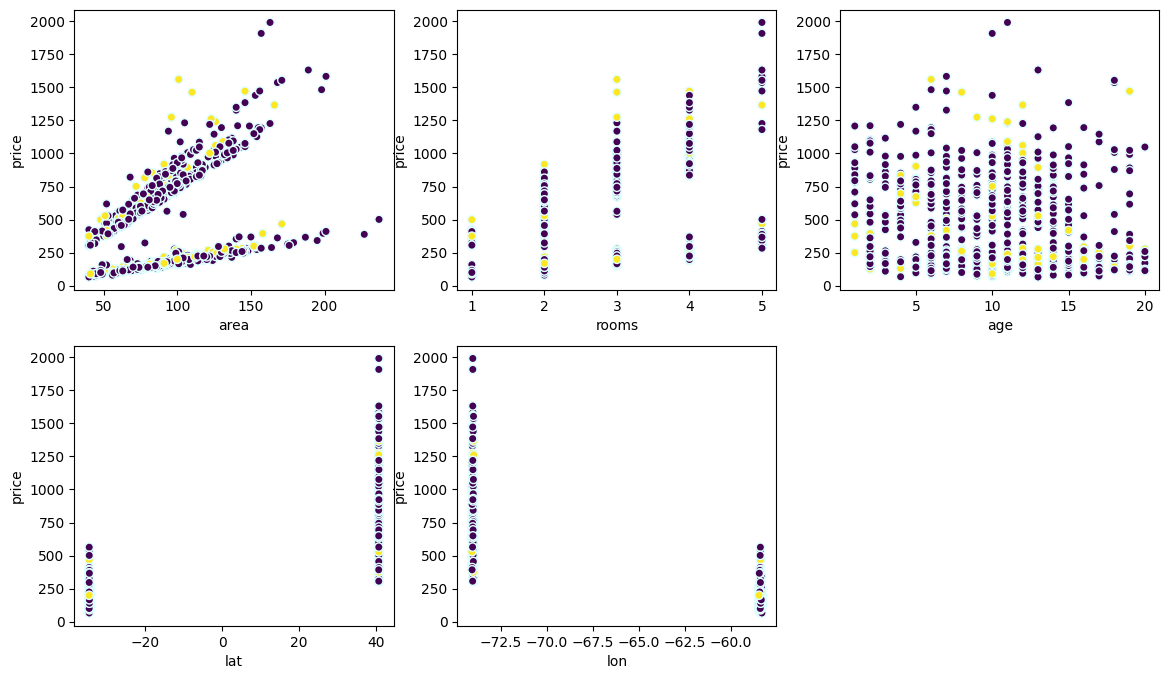

In [15]:
plt.figure(figsize=(14, 8))
other_features : list[str] = ['area', 'rooms', 'age', 'lat', 'lon']
for i in range(1, len(other_features) + 1):
    plt.subplot(2, 3, i)
    plt.scatter(processed_data_nona.casas_dev[other_features[i-1]], processed_data_nona.casas_dev['price'], edgecolors='lightcyan', c=processed_data_nona.casas_dev['has_pool'])
    plt.xlabel(other_features[i-1])
    plt.ylabel('price')
plt.show()